In [1]:
import getpass
import os
from langchain_core.prompts import ChatPromptTemplate
from langchain_experimental.tools import PythonAstREPLTool
from langchain.output_parsers.openai_tools import JsonOutputKeyToolsParser
import pandas as pd
from io import StringIO
from typing import Annotated
from typing_extensions import TypedDict

from langchain_core.messages import ToolMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from pandas.core.frame import DataFrame
from pandas.core.series import Series
import json
# os.environ["OPENAI_API_KEY"] = getpass.getpass('Password: ')
api_key = "sk-pzmVDXe1-rxgtV34fEob57Owp9b7Z7_k-jYKmFaguDT3BlbkFJXR835WsPGSV7P_sjJXS2QGOJBIxgW5wSzwqExklvAA"

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", api_key=api_key)

In [2]:
class State(TypedDict):
    messages: list
    tool: PythonAstREPLTool
    file_info_list: list # (df_name, df_info, file_name)
    loop_times: int

class ChatBot:
    def __init__(self, llm):
        self.llm = llm

    def __call__(self, state: State):
        message = state["messages"][-1] if len(state.get("messages", [])) > 0 else ""
        if "tool" not in state:
            raise ValueError("No python code tool found in the initial state!")
        tool = state["tool"]
        llm_with_tools = self.llm.bind_tools([tool], tool_choice=tool.name)
        df_template = """```
        {df_name}.info()
        File Path of {df_name}: {file_name}
        >>> {df_info}
        ```"""
        df_context = "\n\n".join(
            df_template.format(df_name=df_name, df_info=df_info,
                            file_name=file_name)
            for df_name, df_info, file_name in state.get('file_info_list', [])
        )
        system = f"""You have access to a number of pandas dataframes. \
        Here is the info from each dataframe`:
        {df_context}
        Given a user question about the dataframes, write the Python code to answer it. \
        Return ONLY the valid Python code and nothing else. \
        Don't assume you have access to any libraries other than built-in Python ones, pandas and matplotlib. \
        Ensure that there is not index error when referring to a column name. \
        Always ENSURE that the code return a pandas Dataframe.
        Please CHECKT column name for each dataframe carefully.
        """
        # TODO: check whether need to add the original code in the prompt
        prompt = ChatPromptTemplate.from_messages([("system", system), ("human", "{question}")])
        state["messages"].append((prompt | llm_with_tools).invoke(message.content))
        return state
    
class PythonToolNode:
    """A node that runs the python code received from the last AIMessage"""

    def __init__(self) -> None:
        pass
    
    def __call__(self, state: State):
        if messages := state.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        tool = state["tool"]
        parser = JsonOutputKeyToolsParser(key_name=tool.name, first_tool_only=True)
        code_res = (parser | tool).invoke(message)
        # if isinstance(code_res, DataFrame) or isinstance(code_res, Series):
        #     code_res.to_csv("output_graph.csv",index=False)
        res_info = f"{code_res}"
        if "error" in res_info.lower():
            state["loop_times"] += 1
            if state["loop_times"] > 3:
                new_message = AIMessage(
                    content="Early End"
                )
                return new_message
            res_info = "Modify the code by the error information:\n" + f"Error: {res_info}\nCode:\n{message.tool_calls[0]['args']['query']}" 
            new_message = AIMessage(
                content=res_info
            )
        else:
            new_message = AIMessage(
                content="Ok",
            )
            print("Ok and exit the loop!")
        state["messages"].append(new_message)
        print(f"Modification {state['loop_times']}")
        return state
    
def route_tools(state: State):
    if messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if ai_message.content == "Ok" or ai_message == "Early End":
        return END
    return "Modification"

In [3]:
graph_builder = StateGraph(State)
chatbot = ChatBot(llm=llm)
graph_builder.add_node("chatbot", chatbot)
python_node = PythonToolNode()
graph_builder.add_node("python tool", python_node)
graph_builder.add_conditional_edges(
    "python tool",
    route_tools,
    {"Modification": "chatbot", END: END},
)
graph_builder.add_edge("chatbot", "python tool")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

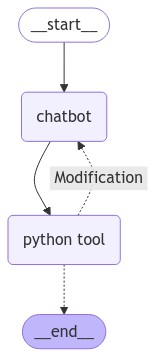

In [4]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [5]:
def create_init_state(csv_file_path_list, prompt):
    df_dict = {}
    df_info_list = []
    buffer = StringIO()
    cur = 1
    for file_path in csv_file_path_list:
        df = pd.read_csv(file_path, delimiter=',')
        file_name = file_path.split('/')[-1]
        print(f"Read the file {file_name}!")
        df.info(buf=buffer)
        info_lines = buffer.getvalue().splitlines()
        trimmed_info = '\n'.join(info_lines[1:-2])
        df_name = f"csv_{cur}"
        cur += 1
        df_info_list.append((df_name, trimmed_info, file_path))
        buffer.truncate(0)
        buffer.seek(0)
        df_dict[df_name] = df.copy()
        print(f"{df_name} : {file_path}")
    tool = PythonAstREPLTool(locals=df_dict)
    message_list = [AIMessage(prompt)]
    state = State(messages=message_list, tool=tool, file_info_list=df_info_list, loop_times=0)
    return state

In [6]:
file_list = ["テスト用データ/other_2/main.csv",
             "テスト用データ/other_2/Yonosuke_sekkei.csv"]
prompt =  "以下の手順でCSVファイルを作成してください。まず、設計ファイルとなるyonosuke_sekkei.csvを確認し、yonosuke_sekkei.csvの1行目をコピーしてそれをそのまま出力ファイルの1行目としてください。\n出力ファイルの2行目以降は、main.csvの値も参照しながら実際の値を埋めてください。yonosuke_sekkei.csvの2行目に値が存在する際には、それぞれの列でmain.csvの何列目の値を参照するかが記載されています。なお、最大2桁のアルファベットで書かれているので、DataFrameで扱う際には数字のインデックスに直して処理してください。また、「I+J」のように足し算で表されている場合は、main.csvの該当する列の値2つを足した値を表します。処理済みデータを'other_2_graph.csv'として出力"
init_state = create_init_state(file_list, prompt)

Read the file main.csv!
csv_1 : テスト用データ/other_2/main.csv
Read the file Yonosuke_sekkei.csv!
csv_2 : テスト用データ/other_2/Yonosuke_sekkei.csv


In [7]:
res = graph.stream(init_state)

In [8]:
for event in res:
    for value in event.values():
        print("Assistant:", value)

Assistant: {'messages': [AIMessage(content="以下の手順でCSVファイルを作成してください。まず、設計ファイルとなるyonosuke_sekkei.csvを確認し、yonosuke_sekkei.csvの1行目をコピーしてそれをそのまま出力ファイルの1行目としてください。\n出力ファイルの2行目以降は、main.csvの値も参照しながら実際の値を埋めてください。yonosuke_sekkei.csvの2行目に値が存在する際には、それぞれの列でmain.csvの何列目の値を参照するかが記載されています。なお、最大2桁のアルファベットで書かれているので、DataFrameで扱う際には数字のインデックスに直して処理してください。また、「I+J」のように足し算で表されている場合は、main.csvの該当する列の値2つを足した値を表します。処理済みデータを'other_2_graph.csv'として出力", additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_10akusbzLoy4TdRX7UwQ1BSH', 'function': {'arguments': '{"query":"import pandas as pd\\n\\n# Read the two CSV files\\nmain_df = pd.read_csv(\'テスト用データ/other_2/main.csv\')\\nyonosuke_df = pd.read_csv(\'テスト用データ/other_2/Yonosuke_sekkei.csv\')\\n\\n# Initialize the output DataFrame with the header from yonosuke_sekkei.csv\\noutput_df = pd.DataFrame(columns=yonosuke_df.columns)\\n\\n# Fill the first row with the header\\noutput_df.loc[0] = yonosuke_df.columns\\n\\

In [9]:
print(len(init_state['messages']))

7


In [12]:
for message in init_state['messages']:
    print(message.content)
    print("".join("-" for _ in range(60)))

以下の手順でCSVファイルを作成してください。まず、設計ファイルとなるyonosuke_sekkei.csvを確認し、yonosuke_sekkei.csvの1行目をコピーしてそれをそのまま出力ファイルの1行目としてください。
出力ファイルの2行目以降は、main.csvの値も参照しながら実際の値を埋めてください。yonosuke_sekkei.csvの2行目に値が存在する際には、それぞれの列でmain.csvの何列目の値を参照するかが記載されています。なお、最大2桁のアルファベットで書かれているので、DataFrameで扱う際には数字のインデックスに直して処理してください。また、「I+J」のように足し算で表されている場合は、main.csvの該当する列の値2つを足した値を表します。処理済みデータを'other_2_graph.csv'として出力
------------------------------------------------------------

------------------------------------------------------------
Modify the code by the error information:
Error: TypeError: ord() expected a character, but string of length 2 found
Code:
import pandas as pd

# Read the two CSV files
main_df = pd.read_csv('テスト用データ/other_2/main.csv')
yonosuke_df = pd.read_csv('テスト用データ/other_2/Yonosuke_sekkei.csv')

# Initialize the output DataFrame with the header from yonosuke_sekkei.csv
output_df = pd.DataFrame(columns=yonosuke_df.columns)

# Fill the first row with the header
output_df.loc[0] = yonosuke_df.columns

# Proc

In [11]:
for message in init_state['messages']:
    if getattr(message, "tool_calls") and len(message.tool_calls) > 0:
        print(message.tool_calls[0]['args']["query"])
        print("".join("-" for _ in range(20)))

import pandas as pd

# Read the two CSV files
main_df = pd.read_csv('テスト用データ/other_2/main.csv')
yonosuke_df = pd.read_csv('テスト用データ/other_2/Yonosuke_sekkei.csv')

# Initialize the output DataFrame with the header from yonosuke_sekkei.csv
output_df = pd.DataFrame(columns=yonosuke_df.columns)

# Fill the first row with the header
output_df.loc[0] = yonosuke_df.columns

# Process each relevant row in yonosuke_sekkei.csv
for idx in range(1, len(yonosuke_df)):
    row_data = []
    for col in yonosuke_df.columns:
        if pd.notnull(yonosuke_df[col][idx]):
            # Get the corresponding column index if it's a letter
            if isinstance(yonosuke_df[col][idx], str) and len(yonosuke_df[col][idx]) <= 2:
                column_index = ord(yonosuke_df[col][idx]) - ord('A')  # Convert letter to index
                row_data.append(main_df.iloc[0, column_index])  # Get value from the main_df
            elif '+' in yonosuke_df[col][idx]:
                # Handle addition case
         